##### 01/21/21
#### FHWA pile data
- regression for Qu
- ANN for Load-Settlement

##### int. to ML with python by Muller and Guido

---
#### 말뚝 지지력 머신러닝 적용

* 데이터 구조
    * feature(특성) : SPT tip, SPT sleeve, 길이, 단면적
    * label : 측정값

In [1]:
from preamble import *
%matplotlib inline


In [2]:
import os
import sys
print("Python 버전:", sys.version)

import pandas as pd
print("pandas 버전:", pd.__version__)

import matplotlib
print("matplotlib 버전:", matplotlib.__version__)

import numpy as np
print("NumPy 버전:", np.__version__)

import scipy as sp
print("SciPy 버전:", sp.__version__)

import IPython
print("IPython 버전:", IPython.__version__)

import sklearn
print("scikit-learn 버전:", sklearn.__version__)

Python 버전: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
pandas 버전: 1.1.5
matplotlib 버전: 3.3.2
NumPy 버전: 1.16.6
SciPy 버전: 1.5.0
IPython 버전: 7.18.1
scikit-learn 버전: 0.22


In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "linearR"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# $Q_u$ Regression
## Get the data

In [4]:
# 이 파일은 열 이름을 나타내는 헤더가 없으므로 header=None으로 지정하고
# "names" 매개변수로 열 이름을 제공합니다
#data = pd.read_csv(
#    os.path.join(mglearn.datasets.DATA_PATH, "fhwa.csv"), header=None, index_col=False,
#    names=['phishaft', 'phitop', 'sigvtip', 'length', 'area', 'qmeasure','qpredict',
#         'source', 'testnum', 'site'  ], encoding='cp949')
# 예제를 위해 몇개의 열만 선택합니다
#data9 = data9[['phishaft', 'phitop', 'sigvtip', 'length', 'area', 'qmeasure','qpredict']]
# IPython.display 함수는 주피터 노트북을 위해 포맷팅된 출력을 만듭니다
#display(data9.head())

data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "FHWA.csv"))
display(data.head())


Project                                 Name    Pile    MaxF  ...    qs3  \
0      788   111 GRL Piles-LTV Cont. Caster, OH   SPO-2  3407.3  ...    NaN   
1      789  112 GRL Piles-ODOT State Rte 22, OH   SPO-1   818.5  ...    NaN   
2       10  35 Seismic Retrofit Program-Hwy 280  SPO-13  1331.8  ...  100.0   
3       10  35 Seismic Retrofit Program-Hwy 280  SPO-14  1169.4  ...  100.0   
4       10  35 Seismic Retrofit Program-Hwy 280  SPO-28  1770.4  ...  100.0   

   qs4  qs5    qst  
0  NaN  NaN    NaN  
1  NaN  NaN    NaN  
2  5.0  4.0  380.0  
3  5.0  4.0  380.0  
4  5.0  4.0  380.0  

[5 rows x 29 columns]

In [5]:
print(data.keys())
print(data.shape)



Index(['Project', 'Name', 'Pile', 'MaxF', 'MaxD', 'Len', 'Dia', 'Qu', 'Ns1',
       'Ns2', 'Ns3', 'Ns4', 'Ns5', 'NB', 'Sand', 'Clay', 'Silt', 'qc1', 'qc2',
       'qc3', 'qc4', 'qc5', 'qct', 'qs1', 'qs2', 'qs3', 'qs4', 'qs5', 'qst'],
      dtype='object')
(54, 29)


In [6]:
# p 48

#data.loc[:,['pileshaft','area']]
#data[:,['phishaft']]
data.head()
data.tail()
data.index
data.columns
#data.describe()
#data[0:3]
#data.loc[:,['phishaft','area']]
#data.iloc[:,0:5]
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Project  54 non-null     int64  
 1   Name     54 non-null     object 
 2   Pile     54 non-null     object 
 3   MaxF     54 non-null     float64
 4   MaxD     54 non-null     float64
 5   Len      54 non-null     float64
 6   Dia      54 non-null     float64
 7   Qu       54 non-null     int64  
 8   Ns1      54 non-null     float64
 9   Ns2      54 non-null     float64
 10  Ns3      54 non-null     float64
 11  Ns4      54 non-null     float64
 12  Ns5      54 non-null     float64
 13  NB       54 non-null     float64
 14  Sand     54 non-null     int64  
 15  Clay     54 non-null     int64  
 16  Silt     54 non-null     int64  
 17  qc1      14 non-null     float64
 18  qc2      14 non-null     float64
 19  qc3      14 non-null     float64
 20  qc4      14 non-null     float64
 21  qc5      14 non-nu

Project      MaxF    MaxD    Len  ...     qs3     qs4     qs5     qst
count    54.00     54.00   54.00  54.00  ...   14.00   14.00   14.00   14.00
mean    780.91   9608.78  -82.87  39.23  ...   77.14   73.07   80.71  263.57
std     399.61  10397.55   76.78  19.99  ...   60.57   95.33  115.02  218.76
min      10.00    667.20 -280.00   9.10  ...   10.00    5.00    4.00   30.00
25%     328.00   3580.82 -104.52  27.05  ...   30.00    5.00    4.00  100.00
50%    1009.00   5971.70  -45.55  36.20  ...   80.00   30.00   30.00  290.00
75%    1034.75  13007.25  -29.35  50.85  ...  100.00  100.00  100.00  380.00
max    1072.00  36000.00   -6.30  92.00  ...  250.00  300.00  400.00  800.00

[8 rows x 27 columns]

In [7]:
data.dtypes

Project      int64
Name        object
Pile        object
MaxF       float64
MaxD       float64
Len        float64
Dia        float64
Qu           int64
Ns1        float64
Ns2        float64
Ns3        float64
Ns4        float64
Ns5        float64
NB         float64
Sand         int64
Clay         int64
Silt         int64
qc1        float64
qc2        float64
qc3        float64
qc4        float64
qc5        float64
qct        float64
qs1        float64
qs2        float64
qs3        float64
qs4        float64
qs5        float64
qst        float64
dtype: object

<AxesSubplot:>

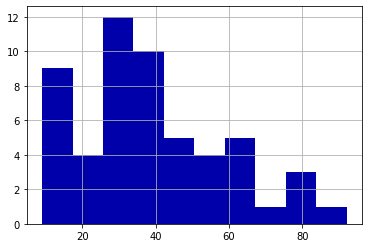

In [8]:
data["Len"].hist()

array([[<AxesSubplot:title={'center':'Project'}>,
        <AxesSubplot:title={'center':'MaxF'}>,
        <AxesSubplot:title={'center':'MaxD'}>,
        <AxesSubplot:title={'center':'Len'}>,
        <AxesSubplot:title={'center':'Dia'}>],
       [<AxesSubplot:title={'center':'Qu'}>,
        <AxesSubplot:title={'center':'Ns1'}>,
        <AxesSubplot:title={'center':'Ns2'}>,
        <AxesSubplot:title={'center':'Ns3'}>,
        <AxesSubplot:title={'center':'Ns4'}>],
       [<AxesSubplot:title={'center':'Ns5'}>,
        <AxesSubplot:title={'center':'NB'}>,
        <AxesSubplot:title={'center':'Sand'}>,
        <AxesSubplot:title={'center':'Clay'}>,
        <AxesSubplot:title={'center':'Silt'}>],
       [<AxesSubplot:title={'center':'qc1'}>,
        <AxesSubplot:title={'center':'qc2'}>,
        <AxesSubplot:title={'center':'qc3'}>,
        <AxesSubplot:title={'center':'qc4'}>,
        <AxesSubplot:title={'center':'qc5'}>],
       [<AxesSubplot:title={'center':'qct'}>,
        <AxesSubplot:ti

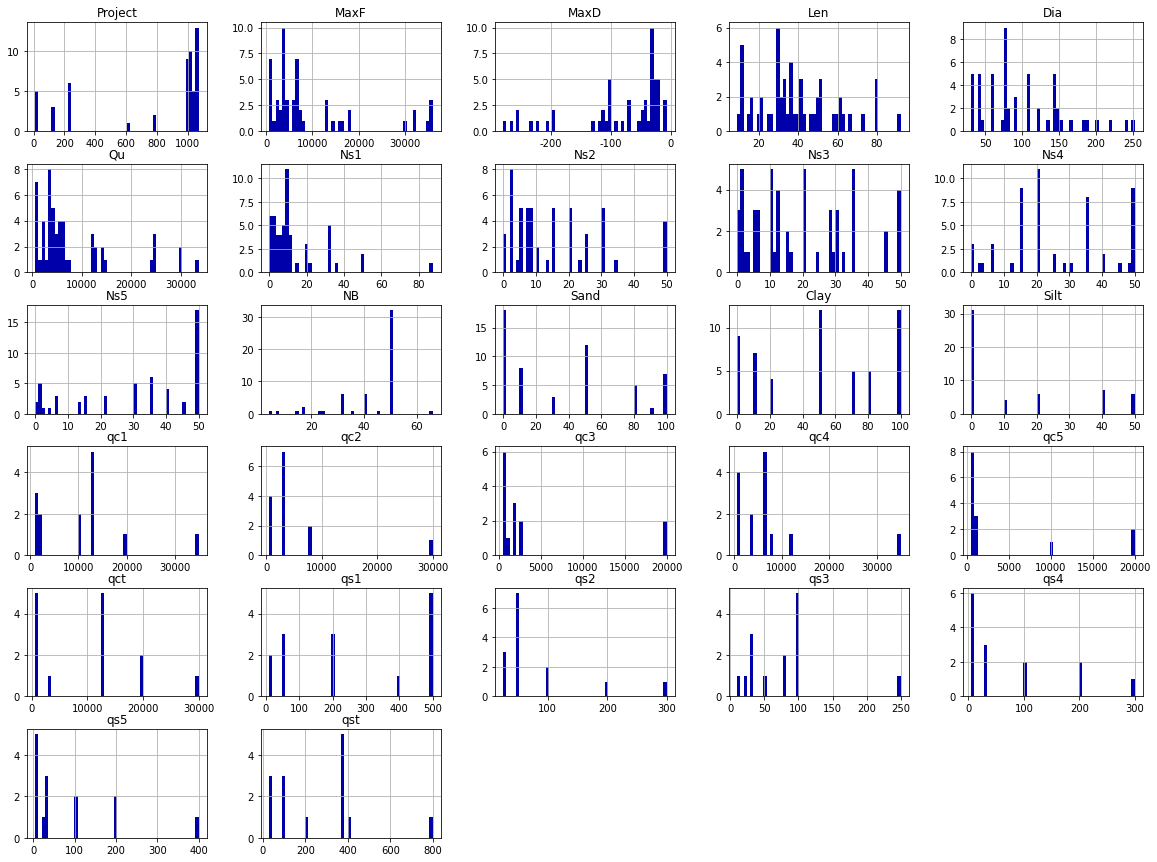

In [9]:
# p49 Hands on

data.hist(bins=50, figsize=(20,15))

## Discover and Visualize the Data to Gain Insights

### *Visualizing data*

P56

<AxesSubplot:xlabel='NB', ylabel='Len'>

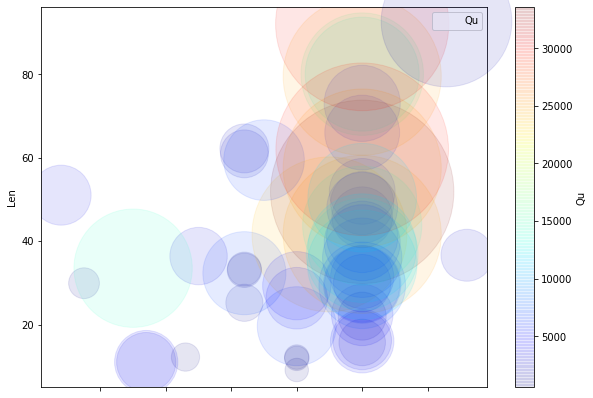

In [10]:
data.plot(kind="scatter", x="NB", y="Len", figsize=(10,7)
          ,alpha=0.1
          ,s=data["Qu"]
          ,label="Qu"
          ,c="Qu", cmap=plt.get_cmap("jet"), colorbar=True)
#          ,c="qu", cmap=plt.get_cmap("jet"), colorbar=False)
#plt.legend()
#plt.show()
#see the high-density areas by alpha

In [11]:
data.head()

Project                                 Name    Pile    MaxF  ...    qs3  \
0      788   111 GRL Piles-LTV Cont. Caster, OH   SPO-2  3407.3  ...    NaN   
1      789  112 GRL Piles-ODOT State Rte 22, OH   SPO-1   818.5  ...    NaN   
2       10  35 Seismic Retrofit Program-Hwy 280  SPO-13  1331.8  ...  100.0   
3       10  35 Seismic Retrofit Program-Hwy 280  SPO-14  1169.4  ...  100.0   
4       10  35 Seismic Retrofit Program-Hwy 280  SPO-28  1770.4  ...  100.0   

   qs4  qs5    qst  
0  NaN  NaN    NaN  
1  NaN  NaN    NaN  
2  5.0  4.0  380.0  
3  5.0  4.0  380.0  
4  5.0  4.0  380.0  

[5 rows x 29 columns]

---
#### Prepare the data for ML algorithm
* *Data Cleaning*
* *Handling Text and Categorical Attributes*
* *Custom Transformers*
* *Feature Scaling*
* *Transformation Pipelines*

---

#### *Add average N and Cone Resistacne*

In [12]:
#data["qu"].dtypes
#data.dtypes
#data["qu"] = pd.to_numeric(data["qu"])
#data["qu"].dtypes

data['mean_N'] = data.iloc[:, 8:13].mean(axis=1)
data['mean_qc'] = data.iloc[:, 17:22].mean(axis=1)
data['mean_qs'] = data.iloc[:, 23:28].mean(axis=1)

In [13]:
#display(data["mean_N"])

#display(data.iloc[0, 8:13])

#df.style.format({'B': "{:0<4.0f}", 'D': '{:+.2f}'})
#df.style.format("{:.2%}")
#data.iloc[0, 8:13].style.format('{:.2f}')
#data['mean_N1'] = data['mean_N']
#data['mean_N2'] = data['mean_N']
#data['mean_N1'] = data['mean_N1'].map('${:,.2f}'.format)
#data['mean_N1'] = data['mean_N1'].map('{:,.3f}'.format)
#print(data['mean_N1'] )
#data.drop(['mean_N1', 'mean_N2'], axis=1)
#del data['mean_N2']
#del data['mean_N1']
#display(data.iloc[0:1,25:])
#display(data)

In [14]:
#df = pd.DataFrame(np.arange(12).reshape(3, 4),
#                  columns=['A', 'B', 'C', 'D'])
#display(df)
#df.drop(['B', 'C'], axis=1)
#df.drop(columns=['B', 'C'])

#### *Handling NaN etc.*

In [15]:
## Select missing values, show two rows
#df[df['qct'].isnull()].head(5)

In [16]:
# Load data, set missing values
df = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "FHWA.csv"),
                na_values=[np.nan, 'None', -999])
# to make blank to blank instead of NaN
#                keep_default_na=False, na_values=[np.nan, 'NONE', -999])
#display(df.iloc[0:1,25:])
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Project  54 non-null     int64  
 1   Name     54 non-null     object 
 2   Pile     54 non-null     object 
 3   MaxF     54 non-null     float64
 4   MaxD     54 non-null     float64
 5   Len      54 non-null     float64
 6   Dia      54 non-null     float64
 7   Qu       54 non-null     int64  
 8   Ns1      54 non-null     float64
 9   Ns2      54 non-null     float64
 10  Ns3      54 non-null     float64
 11  Ns4      54 non-null     float64
 12  Ns5      54 non-null     float64
 13  NB       54 non-null     float64
 14  Sand     54 non-null     int64  
 15  Clay     54 non-null     int64  
 16  Silt     54 non-null     int64  
 17  qc1      14 non-null     float64
 18  qc2      14 non-null     float64
 19  qc3      14 non-null     float64
 20  qc4      14 non-null     float64
 21  qc5      14 non-nu

Project     0
Name        0
Pile        0
MaxF        0
MaxD        0
Len         0
Dia         0
Qu          0
Ns1         0
Ns2         0
Ns3         0
Ns4         0
Ns5         0
NB          0
Sand        0
Clay        0
Silt        0
qc1        40
qc2        40
qc3        40
qc4        40
qc5        40
qct        40
qs1        40
qs2        40
qs3        40
qs4        40
qs5        40
qst        40
dtype: int64

In [17]:
df['mean_N'] = df.iloc[:, 8:13].mean(axis=1)
df['mean_qc'] = df.iloc[:, 17:22].mean(axis=1)
df['mean_qs'] = df.iloc[:, 23:28].mean(axis=1)

### *Looking for corrlations*

In [18]:
# 몇개의 열만 선택합니다
df = df[['MaxF', 'MaxD','Qu', 'Len', 'Dia', 'mean_N', 'NB','mean_qc','qct','mean_qs','qst']]
# IPython.display 함수는 주피터 노트북을 위해 포맷팅된 출력을 만듭니다
display(df.head())

MaxF  MaxD    Qu   Len  ...  mean_qc      qct  mean_qs    qst
0  3407.3 -44.0  2700  36.6  ...      NaN      NaN      NaN    NaN
1   818.5 -27.7   800  12.2  ...      NaN      NaN      NaN    NaN
2  1331.8 -23.7  1180  33.0  ...   4660.0  12800.0    131.8  380.0
3  1169.4 -40.7  1150  33.3  ...   4660.0  12800.0    131.8  380.0
4  1770.4 -32.8  1379  25.2  ...   4660.0  12800.0    131.8  380.0

[5 rows x 11 columns]

##### *Dropping the raw with NaN for a feature*
for cone penetration data

In [19]:
# only drop rows where all columns are NaN
#df1 = df.dropna(how='all')
# drop rows that have fewer than 4 real values
# df.dropna(thresh=4)
# only drop rows where NaN appear in specific columns (here: 'C')
#df.dropna(subset=['C'])

In [20]:
#drop feature including NaN
df1 = df.dropna(axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MaxF    54 non-null     float64
 1   MaxD    54 non-null     float64
 2   Qu      54 non-null     int64  
 3   Len     54 non-null     float64
 4   Dia     54 non-null     float64
 5   mean_N  54 non-null     float64
 6   NB      54 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 3.1 KB


In [21]:
corr_matrix = df1.corr()
corr_matrix["Qu"].sort_values(ascending=False)

Qu        1.00
MaxF      0.99
Dia       0.78
Len       0.56
NB        0.30
mean_N    0.04
MaxD     -0.75
Name: Qu, dtype: float64

In [22]:
df2 = df.dropna(axis = 0)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 2 to 27
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MaxF     14 non-null     float64
 1   MaxD     14 non-null     float64
 2   Qu       14 non-null     int64  
 3   Len      14 non-null     float64
 4   Dia      14 non-null     float64
 5   mean_N   14 non-null     float64
 6   NB       14 non-null     float64
 7   mean_qc  14 non-null     float64
 8   qct      14 non-null     float64
 9   mean_qs  14 non-null     float64
 10  qst      14 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 1.3 KB


In [23]:
corr_matrix = df2.corr()
corr_matrix["Qu"].sort_values(ascending=False)

Qu         1.00
MaxF       0.99
Dia        0.67
NB         0.54
mean_N     0.08
mean_qc    0.06
qct       -0.10
Len       -0.12
qst       -0.23
mean_qs   -0.35
MaxD      -0.55
Name: Qu, dtype: float64

### *Experimenting with Attribute Combinations*

array([[<AxesSubplot:xlabel='MaxF', ylabel='MaxF'>,
        <AxesSubplot:xlabel='MaxD', ylabel='MaxF'>,
        <AxesSubplot:xlabel='Qu', ylabel='MaxF'>,
        <AxesSubplot:xlabel='Len', ylabel='MaxF'>,
        <AxesSubplot:xlabel='Dia', ylabel='MaxF'>,
        <AxesSubplot:xlabel='mean_N', ylabel='MaxF'>,
        <AxesSubplot:xlabel='NB', ylabel='MaxF'>],
       [<AxesSubplot:xlabel='MaxF', ylabel='MaxD'>,
        <AxesSubplot:xlabel='MaxD', ylabel='MaxD'>,
        <AxesSubplot:xlabel='Qu', ylabel='MaxD'>,
        <AxesSubplot:xlabel='Len', ylabel='MaxD'>,
        <AxesSubplot:xlabel='Dia', ylabel='MaxD'>,
        <AxesSubplot:xlabel='mean_N', ylabel='MaxD'>,
        <AxesSubplot:xlabel='NB', ylabel='MaxD'>],
       [<AxesSubplot:xlabel='MaxF', ylabel='Qu'>,
        <AxesSubplot:xlabel='MaxD', ylabel='Qu'>,
        <AxesSubplot:xlabel='Qu', ylabel='Qu'>,
        <AxesSubplot:xlabel='Len', ylabel='Qu'>,
        <AxesSubplot:xlabel='Dia', ylabel='Qu'>,
        <AxesSubplot:xlabel='mea

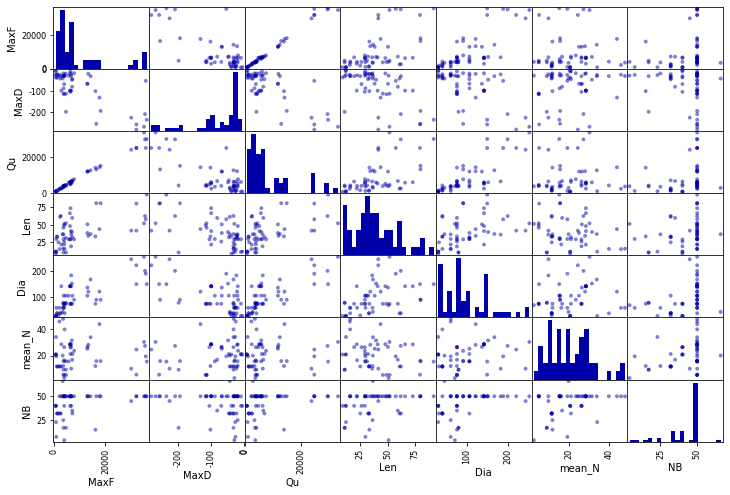

In [24]:
from pandas.plotting import scatter_matrix
attributes = ['MaxF', 'MaxD','Qu', 'Len', 'Dia', 'mean_N', 'NB']
scatter_matrix(df[attributes], figsize=(12,8),  s=60, alpha=.5,
                hist_kwds={'bins': 20})

In [25]:
print(df.keys())

Index(['MaxF', 'MaxD', 'Qu', 'Len', 'Dia', 'mean_N', 'NB', 'mean_qc', 'qct',
       'mean_qs', 'qst'],
      dtype='object')


## Select and Train a Model
* *training and evaluatin on the training set*
* *better evaluation using cross-validations*

---

In [26]:
df.describe()

MaxF    MaxD        Qu    Len  ...   mean_qc       qct  mean_qs  \
count     54.00   54.00     54.00  54.00  ...     14.00     14.00    14.00   
mean    9608.78  -82.87   8178.13  39.23  ...   6081.43  10057.14   114.69   
std    10397.55   76.78   8480.00  19.99  ...   5717.27   9262.14    58.21   
min      667.20 -280.00    550.00   9.10  ...    940.00    600.00    33.00   
25%     3580.82 -104.52   3300.00  27.05  ...   2440.00   1000.00    68.00   
50%     5971.70  -45.55   4828.00  36.20  ...   4660.00  12800.00   131.80   
75%    13007.25  -29.35  11800.00  50.85  ...   6985.00  12800.00   145.15   
max    36000.00   -6.30  33611.00  92.00  ...  18600.00  30000.00   210.00   

          qst  
count   14.00  
mean   263.57  
std    218.76  
min     30.00  
25%    100.00  
50%    290.00  
75%    380.00  
max    800.00  

[8 rows x 11 columns]

In [27]:
print("Original features:\n", list(df.columns), "\n")
df_dummies = pd.get_dummies(df)
print("Features after get_dummies:\n", list(df_dummies.columns))

Original features:
 ['MaxF', 'MaxD', 'Qu', 'Len', 'Dia', 'mean_N', 'NB', 'mean_qc', 'qct', 'mean_qs', 'qst'] 

Features after get_dummies:
 ['MaxF', 'MaxD', 'Qu', 'Len', 'Dia', 'mean_N', 'NB', 'mean_qc', 'qct', 'mean_qs', 'qst']


#### Target and Features

In [28]:
# extract numpy arrays
features = df.iloc[:,3:7]
X = features.values
y = df['Qu'].values
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))


X.shape: (54, 4) y.shape: (54,)


In [29]:
# df is the data frame ; X is ndarray
X_dataframe = pd.DataFrame(df, columns=df.columns[3:6])

array([[<AxesSubplot:xlabel='Len', ylabel='Len'>,
        <AxesSubplot:xlabel='Dia', ylabel='Len'>,
        <AxesSubplot:xlabel='mean_N', ylabel='Len'>],
       [<AxesSubplot:xlabel='Len', ylabel='Dia'>,
        <AxesSubplot:xlabel='Dia', ylabel='Dia'>,
        <AxesSubplot:xlabel='mean_N', ylabel='Dia'>],
       [<AxesSubplot:xlabel='Len', ylabel='mean_N'>,
        <AxesSubplot:xlabel='Dia', ylabel='mean_N'>,
        <AxesSubplot:xlabel='mean_N', ylabel='mean_N'>]], dtype=object)

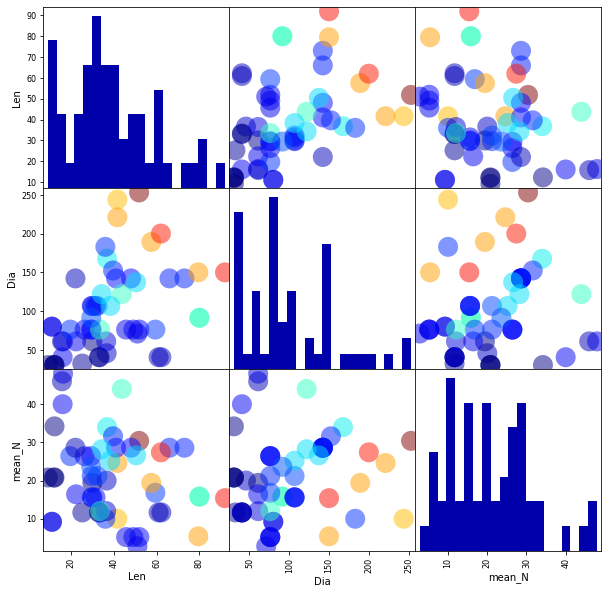

In [30]:
# 데이터프레임을 사용해 y_train에 따라 색으로 구분된 산점도 행렬을 만듭니다.
pd.plotting.scatter_matrix(X_dataframe, c=y, figsize=(10, 10), marker='o',
                           hist_kwds={'bins': 20},
                           s=400,
                           alpha=.5,
                        cmap=plt.get_cmap("jet"),
#cmap=mglearn.cm3
                                           )
#                            ,label="qmeasure")
#pd.plotting.scatter_matrix(X_dataframe,   figsize=(15, 15), marker='o',
#                           hist_kwds={'bins': 20})

<AxesSubplot:xlabel='Len', ylabel='Dia'>

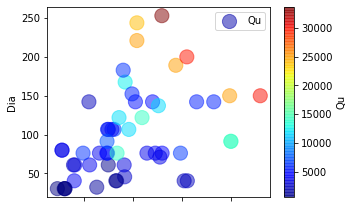

In [31]:
df.plot(kind="scatter", x="Len", y="Dia",alpha=0.5,
#          s=data1["qmeasure"],
            s=200,
           label="Qu",figsize=(5,3.5),
          c="Qu", cmap=plt.get_cmap("jet"), colorbar=True)
#          c="Qu", cmap=plt.get_cmap("jet"), colorbar=False)
#plt.legend()
#plt.show()
#see the high-density areas by alpha

In [32]:
# for one-feature only

print("Original features:\n", list(df.columns), "\n")

Original features:
 ['MaxF', 'MaxD', 'Qu', 'Len', 'Dia', 'mean_N', 'NB', 'mean_qc', 'qct', 'mean_qs', 'qst'] 



In [33]:
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (54, 4) y.shape: (54,)


In [34]:
y = y.reshape(-1,1)
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))

X.shape: (54, 4)
y.shape: (54, 1)


#### Select and Train a Model
* *training and evaluatin on the training set*
* *better evaluation using cross-validations*
---

In [35]:
#*************************************************************************************
# p 53 int to ML with python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# needs stratified sampling for small data set: make strata and sample right number of instances from each stratum ....


### k-neighbors regression

In [36]:
X_len = X[:,0]
X_len = X_len.reshape(-1, 1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_len, y, random_state=42)

In [38]:
from sklearn.neighbors import KNeighborsRegressor

# 이웃의 수를 3으로 하여 모델의 객체를 만듭니다
reg = KNeighborsRegressor(n_neighbors=9)
reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

In [39]:
print("테스트 세트 예측:\n", reg.predict(X_test))

테스트 세트 예측:
 [[19145.667]
 [ 2688.778]
 [ 2688.778]
 [ 5031.667]
 [ 5136.556]
 [13901.222]
 [ 8729.333]
 [ 8206.222]
 [ 5136.556]
 [17123.444]
 [11933.222]
 [ 2688.778]
 [ 2688.778]
 [13901.222]]


In [40]:
print("테스트 세트 R^2: {:.2f}".format(reg.score(X_test.reshape(-1,1), y_test)))

테스트 세트 R^2: -0.36


#### KNeighborsRegressor 분석

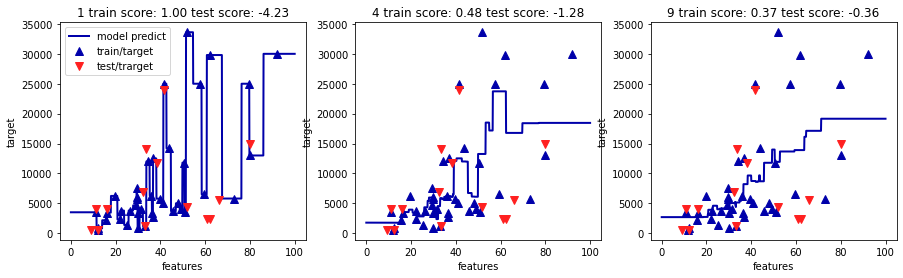

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# -3 과 3 사이에 1,000 개의 데이터 포인트를 만듭니다
line = np.linspace(0, 100, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 4, 9], axes):
    # 1, 3, 9 이웃을 사용한 예측을 합니다
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)

    ax.set_title(
        "{} train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train), reg.score(X_test, y_test)))
    ax.set_xlabel("features")
    ax.set_ylabel("target")
axes[0].legend(["model predict", "train/target", "test/trarget"], loc="best")

### 선형 모델
#### 선형 회귀 모델

#### 선형회귀(최소제곱법)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#lr = LinearRegression().fit(X_train[:,0:2], y_train)
lr = LinearRegression().fit(X_train, y_train)

print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))

#print("Training set score: {:.2f}".format(lr.score(X_train[:,0:2], y_train)))
#print("Test score: {:.2f}".format(lr.score(X_test[:,0:2], y_test)))
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test score: {:.2f}".format(lr.score(X_test, y_test)))

lr.coef_: [[180.243  98.965  64.62  -30.212]]
lr.intercept_: [-9153.65]
Training set score: 0.71
Test score: 0.43


## Interpreting coefficients: scale matters

In [44]:
#    line = np.linspace(25, 38, 100).reshape(-1, 1)

   # lr = LinearRegression().fit(X_train, y_train)
  #  print("w[0]: %f  b: %f" % (lr.coef_[0], lr.intercept_))
print("lr.coef_: {}".format(lr.coef_[0,0]))

print (lr.predict(X_test))
  #  plt.figure(figsize=(8, 8))
  #  plt.plot(line, lr.predict(line))

lr.coef_: 180.242513594233
[[13821.558]
 [-4359.394]
 [-3800.642]
 [ 7630.924]
 [ 4747.879]
 [ 5861.456]
 [21758.802]
 [ 8427.041]
 [  652.447]
 [17152.73 ]
 [ 6567.5  ]
 [-1177.588]
 [  827.13 ]
 [ 5627.14 ]]


In [45]:
column_names = ['Len', 'Dia', 'mean_N', 'NB']
feature_names = np.array([column_names])
feature_names = feature_names.reshape(-1, 1)
coefs = pd.DataFrame(
    lr.coef_.T,
    columns=['Coefficients'], index=feature_names
)
coefs

Coefficients
(Len,)           180.24
(Dia,)            98.97
(mean_N,)         64.62
(NB,)            -30.21

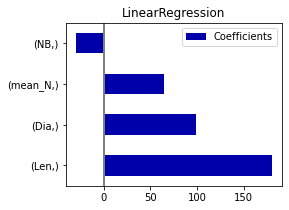

In [46]:
coefs.plot(kind='barh', figsize=(5, 3))
plt.title('LinearRegression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Multiplying the coefficients by the standard deviation of the related
feature would reduce all the coefficients to the same unit of measure.
As we will see `after<scaling_num>` this is **equivalent to normalize
numerical variables to their standard deviation**,
as $y = \sum{coef_i \times X_i} =
\sum{(coef_i \times std_i) \times (X_i / std_i)}$.

In that way, we emphasize that the
greater the variance of a feature, the larger the weight of the corresponding
coefficient on the output, all else being equal.


<AxesSubplot:>

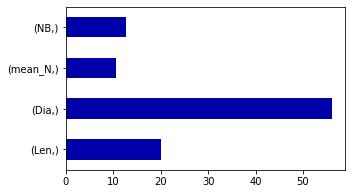

In [47]:
X_df = pd.DataFrame(X, columns=feature_names)
X_df.std(axis=0).plot(kind='barh', figsize=(5, 3))

In [48]:
(lr.coef_*np.array(X_df.std(axis=0))).T

array([[3602.33 ],
       [5544.644],
       [ 686.623],
       [-384.021]])

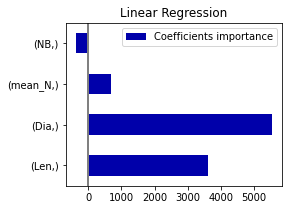

In [49]:
coefs2 = pd.DataFrame(
    (lr.coef_*np.array(X_df.std(axis=0))).T,
    columns=['Coefficients importance'], index=feature_names
)
coefs2.plot(kind='barh', figsize=(5, 3))
plt.title('Linear Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MaxF     54 non-null     float64
 1   MaxD     54 non-null     float64
 2   Qu       54 non-null     int64  
 3   Len      54 non-null     float64
 4   Dia      54 non-null     float64
 5   mean_N   54 non-null     float64
 6   NB       54 non-null     float64
 7   mean_qc  14 non-null     float64
 8   qct      14 non-null     float64
 9   mean_qs  14 non-null     float64
 10  qst      14 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 4.8 KB


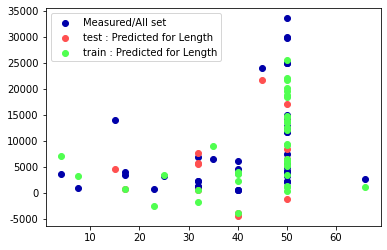

In [51]:
p = lr.predict(X_test)
pt = lr.predict(X_train)

#plt.scatter(lr.predict(X_test[:,0:2]), y_test, s=10)
#plt.scatter(X_test[:,0],y_test,label='Measured/test set')
plt.scatter(X[:,3],y,label='Measured/All set')
plt.scatter(X_test[:,3], p,label='test : Predicted for Length')
plt.scatter(X_train[:,3], pt,label='train : Predicted for Length')
plt.legend( loc="best")


Saving figure lr predicted


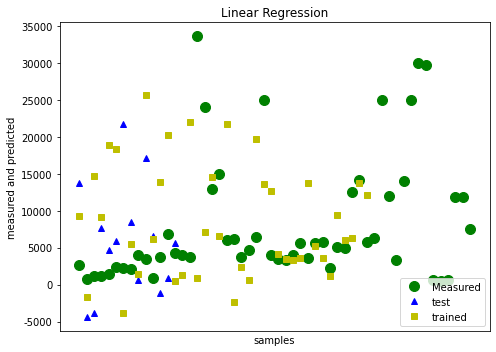

In [52]:
plt.figure(figsize=(7, 5))
plt.plot(y, 'go', label='Measured', ms =10)
plt.plot(p, 'b^', label='test')
plt.plot(pt, 'ys', label='trained')
# ms = marker size
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('measured and predicted')
plt.xlabel('samples')
plt.legend(loc=4)
plt.title('Linear Regression')
save_fig('lr predicted')
plt.show()

#### StandardScaling
#### Refer to "Ensemble" ------->
# ********************************************************************************

In [53]:
list2 = list(df)
list2[3]
list(df)[3]

'Len'

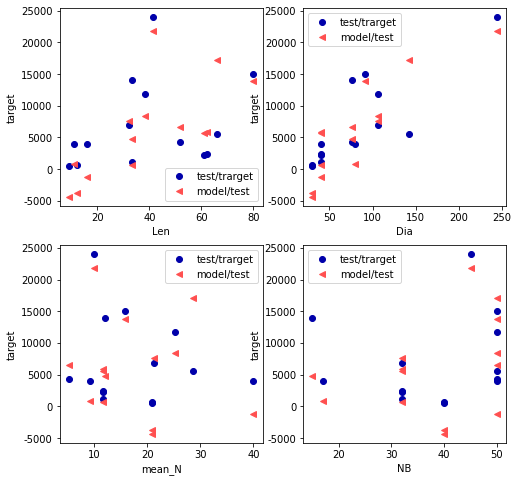

In [54]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes = axes.reshape(-1)
for n_feature, ax in zip([0,1,2,3], axes):
    ax.plot(X_test[:,n_feature],y_test,'o')
#    ax.plot(X_train[:,n_feature],y_train, '<')
    ax.plot(X_test[:,n_feature],p, '<')
#    ax.plot(X_train[:,n_feature],pt, '>')
#    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.set_xlabel(list(df)[n_feature+3])
    ax.set_ylabel("target")
#    ax.legend(["test/trarget", "train/target", "model/train","model/test"], loc="best")
    ax.legend(["test/trarget", "model/test"], loc="best")

#### plot result in various ways

In [55]:
df.describe().loc[['max','min'],['Len','Dia', 'mean_N','NB']]

Len    Dia  mean_N    NB
max  92.0  253.0    48.0  66.0
min   9.1   30.5     2.8   4.0

In [56]:
# predicted for min and max X, prepare the data xst
#xst = np.array([X_test[0,:], X_test[1,:]])
xst = np.array([[9,  30, 3, 4], [92, 253, 48,66]])

In [57]:
print (xst)
p = lr.predict(xst)

[[  9  30   3   4]
 [ 92 253  48  66]]


In [58]:
p

array([[-4489.5  ],
       [33574.612]])

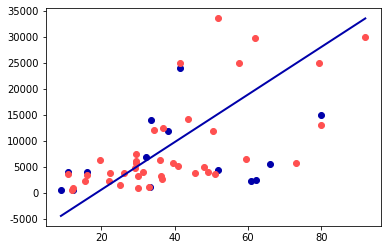

In [59]:
plt.plot(xst[:,0], p)
plt.scatter(X_test[:,0],y_test)
plt.scatter(X_train[:,0],y_train)

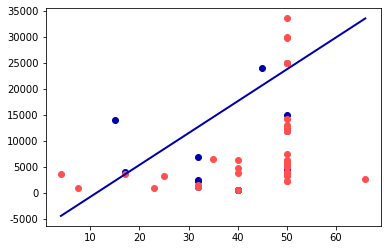

In [60]:
plt.plot(xst[:,3], p)
plt.scatter(X_test[:,3],y_test)
plt.scatter(X_train[:,3],y_train)

### Surface Plot

In [61]:
# surface plot
######################## Prepare model data point for visualization ###############################

x0 = X_train[:, 0] #area
x1 = X_train[:, 1] # length
z = y_train

x0_pred = np.linspace(9, 92, 30)   # range of Len values
x1_pred = np.linspace(30, 253, 30)  # range of Dia values
x2_pred = np.linspace(2, 48, 30)  # range of mean_N values
x3_pred = np.linspace(4, 66, 30)  # range of NB values
xx0_pred, xx1_pred = np.meshgrid(x0_pred, x1_pred)
xx0_pred, xx2_pred = np.meshgrid(x0_pred, x2_pred)
xx0_pred, xx3_pred = np.meshgrid(x0_pred, x3_pred)

model_viz = np.array([xx0_pred.flatten(), xx1_pred.flatten(),
                      xx2_pred.flatten(), xx3_pred.flatten()]).T

In [62]:
# for Len and Dia
################################################ Train #############################################
predicted = lr.predict(model_viz)

In [63]:
############################################## Evaluate ############################################
r2 = lr.score(X_train, y_train)
print(r2)

0.7124351586892744


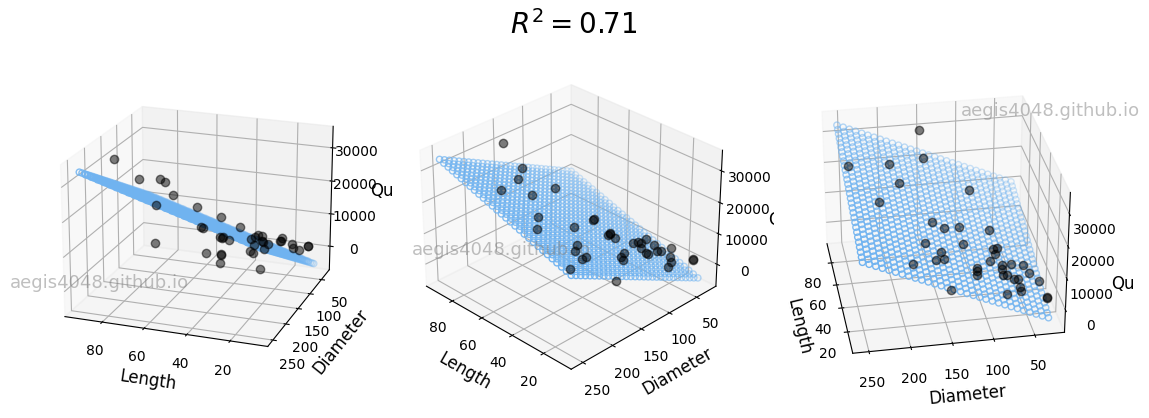

In [64]:
x0 = X_train[:, 0] #area
x1 = X_train[:, 1] # length
z = y_train

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]
z_series = pd.Series(z.flatten())


for ax in axes:
    ax.plot(x0, x1, z_series, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx0_pred.flatten(), xx1_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Diameter', fontsize=12)
    ax.set_zlabel('Qu', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=20, azim=110)
ax2.view_init(elev=30, azim=135)
ax3.view_init(elev=30, azim=170)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

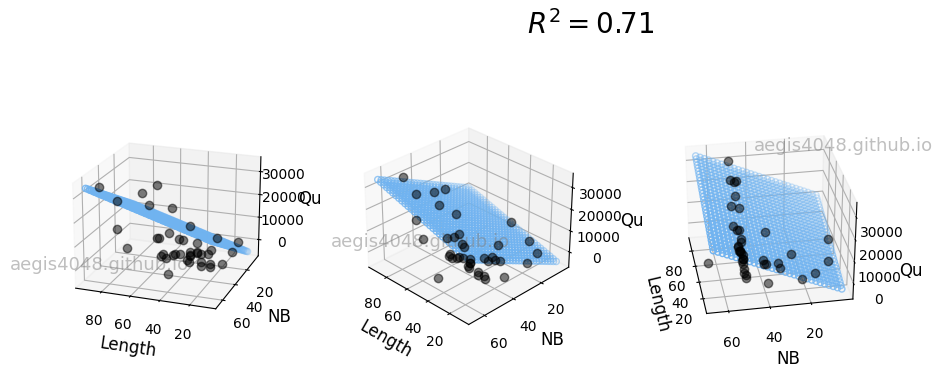

In [65]:
#######################################################
x0 = X_train[:, 0] #area
x1 = X_train[:, 3] # length
z = y_train

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')

axes = [ax1, ax2, ax3]
z_series = pd.Series(z.flatten())


for ax in axes:
    ax.plot(x0, x1, z_series, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx0_pred.flatten(), xx3_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('NB', fontsize=12)
    ax.set_zlabel('Qu', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=20, azim=110)
ax2.view_init(elev=30, azim=135)
ax3.view_init(elev=30, azim=170)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

#### Ridge Regression

In [66]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("훈련 세트 점수: {:.2f}".format(ridge.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(ridge.score(X_test, y_test)))

훈련 세트 점수: 0.71
테스트 세트 점수: 0.43


In [67]:
ridge10 = Ridge(alpha=50).fit(X_train, y_train)
print("훈련 세트 점수: {:.2f}".format(ridge10.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(ridge10.score(X_test, y_test)))

훈련 세트 점수: 0.71
테스트 세트 점수: 0.44


In [68]:
#yyy = y_train.flatten()
ridge01 = Ridge(alpha=5000).fit(X_train, y_train)
print("훈련 세트 점수: {:.2f}".format(ridge01.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(ridge01.score(X_test, y_test)))

훈련 세트 점수: 0.70
테스트 세트 점수: 0.56


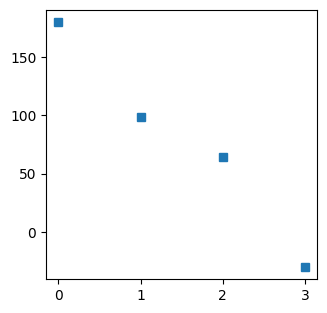

In [69]:
rr = ridge.coef_.flatten()
plt.figure(figsize=(3.5,3.5))
plt.plot(rr, 's', label="Ridge alpha=1")

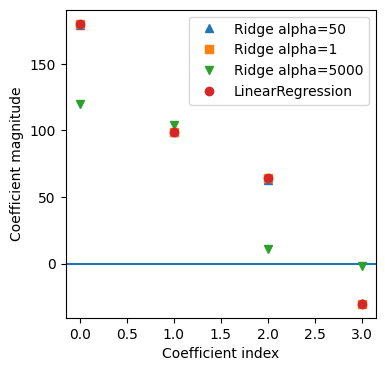

In [70]:
plt.figure(figsize=(4,4))
plt.plot(ridge10.coef_.flatten(), '^', label="Ridge alpha=50")
plt.plot(ridge.coef_.flatten(), 's', label="Ridge alpha=1")
plt.plot(ridge01.coef_.flatten(), 'v', label="Ridge alpha=5000")

plt.plot(lr.coef_.flatten(), 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
#plt.ylim(-25, 25)
plt.legend( loc="upper right")

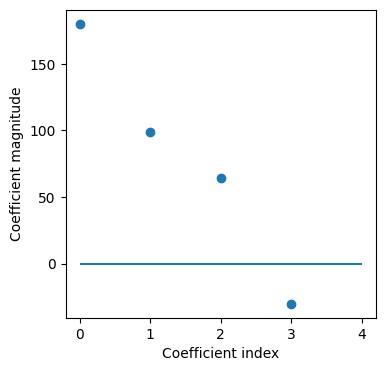

In [71]:
plt.figure(figsize=(4,4))
plt.plot(lr.coef_.flatten(), 'o', label="LinearRegression")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines(0, 0, len(lr.coef_.flatten()))

(-1.5, 1.1)

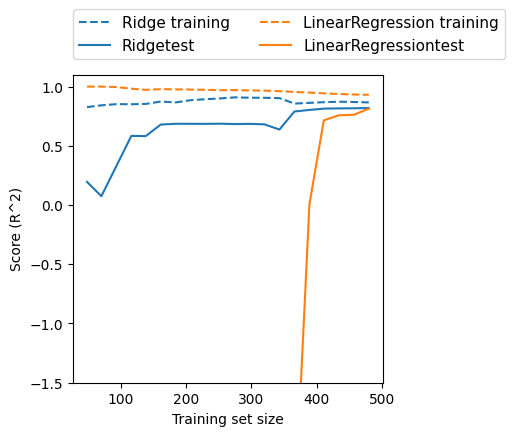

In [72]:
plt.figure(figsize=(4,4))

mglearn.plots.plot_ridge_n_samples()
plt.ylim(-1.5, 1.1)

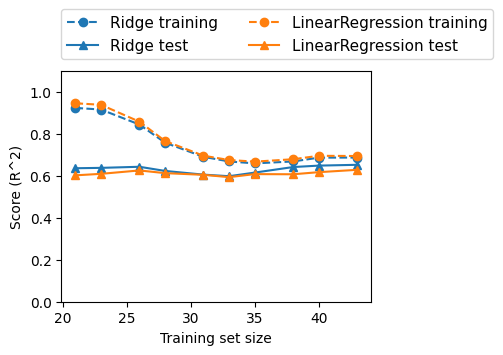

In [73]:
from sklearn.model_selection import learning_curve, KFold

def plot_learning_curve3(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(
#        est, X, y, train_sizes=np.linspace(.1, 1, 5) )
        est, X, y, train_sizes=np.linspace(.5, 1, 10), cv=KFold(5, shuffle=True, random_state=1))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--o',
                    label=estimator_name + " training")
    plt.plot(training_set_size, test_scores.mean(axis=1), '-^',
             label=estimator_name + " test", c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.ylabel('Score (R^2)')
    plt.ylim(0, 1.1)
#    plt.ylim(-1.5, 1.1)


def plot_ridge_n_samples3(X, y):

    plot_learning_curve3(Ridge(alpha=5000), X, y)
    plot_learning_curve3(LinearRegression(), X, y)
    plt.legend(loc=(0, 1.05), ncol=2, fontsize=11)

plt.figure(figsize=(4,3))

#mglearn.plots.plot_ridge_n_samples3(X,y)
plot_ridge_n_samples3(X,y)

### Lasso
L1 norm - outlier에 덜 민감
L1, L2 norm 에 대해서는 mynote 용어.ipynb  참조


In [74]:
# Hands on p.140
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=5000)
lasso_reg.fit(X_train, y_train)
lasso_reg.predict(X_test)
print("훈련 세트 점수: {:.2f}".format(lasso_reg.score(X_train, y_train)))
print("테스트 세트 점수: {:.2f}".format(lasso_reg.score(X_test, y_test)))



훈련 세트 점수: 0.71
테스트 세트 점수: 0.49


## SVM Regression
    Hands on p. 162


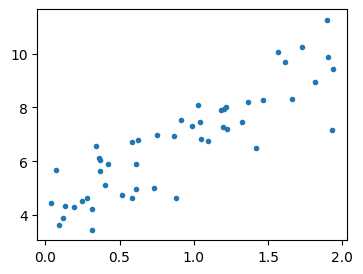

In [75]:
np.random.seed(42)
m = 50
X3 = 2 * np.random.rand(m, 1)
y3 = (4 + 3 * X3 + np.random.randn(m, 1)).ravel()
plt.figure(figsize=(4,3))
plt.plot(X3,y3, ".")

In [76]:
from sklearn.svm import LinearSVR

svm_reg3 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg3.fit(X3, y3)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

###### *def find_support_vectors(svm_reg, X, y)*

In [77]:
svm_reg13 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg23 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg13.fit(X3, y3)
svm_reg23.fit(X3, y3)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg13.support_ = find_support_vectors(svm_reg13, X3, y3)
svm_reg23.support_ = find_support_vectors(svm_reg23, X3, y3)

eps_x1 = 1
eps_y_pred = svm_reg13.predict([[eps_x1]])


#### Create a function to save the figures.

###### *def save_fig*

In [78]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "hands_On"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

###### *def plot_svm_regression*

Saving figure svm_regression_plot


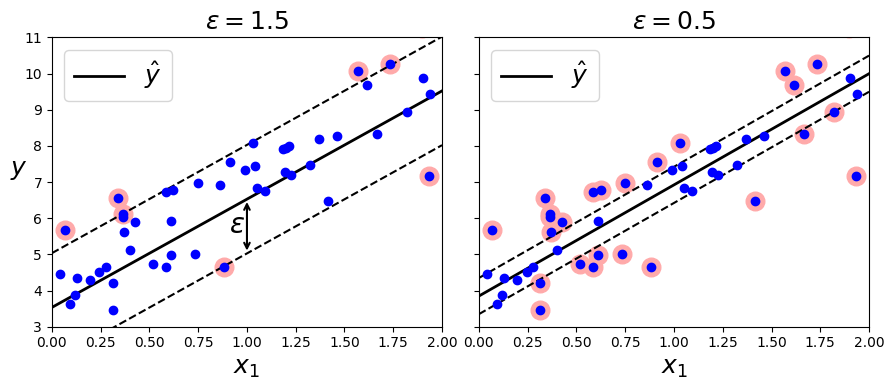

In [79]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg13, X3, y3, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg13.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg13.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg23, X3, y3, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg23.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [80]:
np.random.seed(42)
m = 100
X4 = 2 * np.random.rand(m, 1) - 1
y4 = (0.2 + 0.1 * X4 + 0.5 * X4**2 + np.random.randn(m, 1)/10).ravel()

**Note**: to be future-proof, we set `gamma="scale"`, as this will be the default value in Scikit-Learn 0.22.

In [81]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X4, y4)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [82]:
from sklearn.svm import SVR

svm_poly_reg14 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg24 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg14.fit(X4, y4)
svm_poly_reg24.fit(X4, y4)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


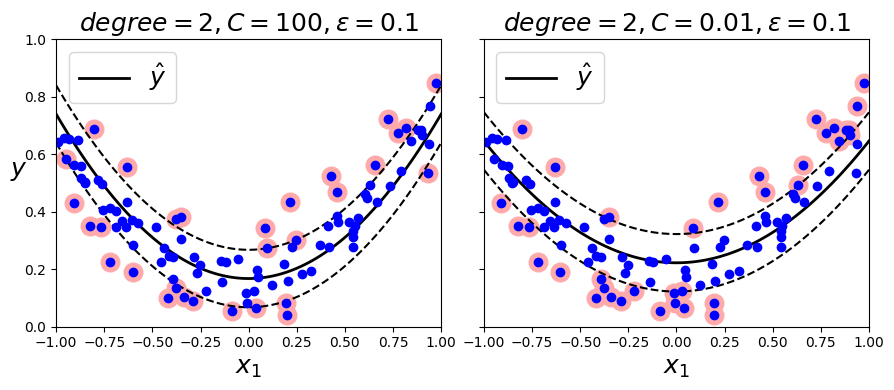

In [83]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg14, X4, y4, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg14.degree, svm_poly_reg14.C, svm_poly_reg14.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg24, X4, y4, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg24.degree, svm_poly_reg24.C, svm_poly_reg24.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

#### SVM for pile data
#### Target and Features again

In [84]:
# extract numpy arrays
features = df.iloc[:,3:7]
X = features.values
y = df['Qu'].values
print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (54, 4) y.shape: (54,)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [86]:
#from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1000, random_state=42)
svm_reg.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=1000, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [87]:
svm_reg1 = LinearSVR(epsilon=8000, random_state=42)
svm_reg2 = LinearSVR(epsilon=2000, random_state=42)
svm_reg1.fit(X_train, y_train)
svm_reg2.fit(X_train, y_train)

#def find_support_vectors(svm_reg, X, y):
#    y_pred = svm_reg.predict(X)
#    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
#    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X_train, y_train)
svm_reg2.support_ = find_support_vectors(svm_reg2, X_train, y_train)

print (svm_reg1.support_)

[[ 0]
 [ 5]
 [ 9]
 [11]
 [15]
 [18]
 [20]]


In [88]:
#eps_x2 = np.array([[1,1,1,1]])
eps_x2 = 1
eps_y_pred = svm_reg1.predict([[eps_x2,eps_x2,eps_x2,eps_x2]] )

In [89]:
df.loc[:,["Qu"]]
df.describe()
df.describe().loc[['max','min'],['Len','Dia', 'mean_N','NB']]


#data.loc[:,['phishaft','area']]
#data.iloc[:,0:5]


Len    Dia  mean_N    NB
max  92.0  253.0    48.0  66.0
min   9.1   30.5     2.8   4.0

[[  9  30   3   4]
 [ 92 253  48  66]]


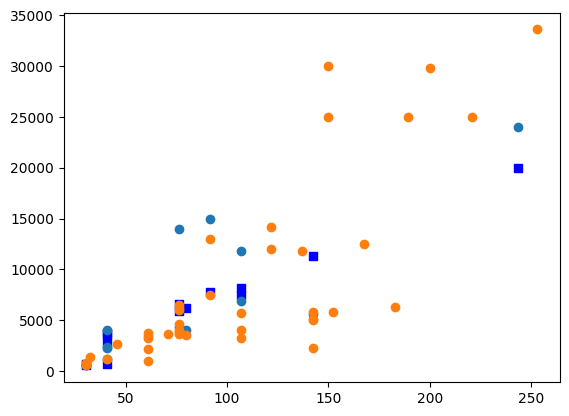

In [90]:
# predicted for min and max X, prepare the data xst
#xst = np.array([X_test[0,:], X_test[1,:]])
svm_reg = LinearSVR(epsilon=100, random_state=42)
svm_reg.fit(X_train, y_train)

xst = np.array([[9,  30, 3, 4], [92, 253, 48,66]])
print (xst)

y_pred_xst = svm_reg.predict(xst)

y_pred = svm_reg.predict(X_test)


#plt.plot(xst[:,0], y_pred_xst)
#plt.plot(xst[:,1], y_pred_xst)
plt.scatter(X_test[:,1], y_pred, color='b', marker='s')
plt.scatter(X_test[:,1],y_test)
plt.scatter(X_train[:,1],y_train)

### Surface Plot for SVM

In [91]:
# surface plot
######################## Prepare model data point for visualization ###############################

x0 = X_train[:, 0] #area
x1 = X_train[:, 1] # length
z = y_train

x0_pred = np.linspace(9, 92, 30)   # range of Len values
x1_pred = np.linspace(30, 253, 30)  # range of Dia values
x2_pred = np.linspace(2, 48, 30)  # range of mean_N values
x3_pred = np.linspace(4, 66, 30)  # range of NB values
xx0_pred, xx1_pred = np.meshgrid(x0_pred, x1_pred)
xx0_pred, xx2_pred = np.meshgrid(x0_pred, x2_pred)
xx0_pred, xx3_pred = np.meshgrid(x0_pred, x3_pred)

model_viz = np.array([xx0_pred.flatten(), xx1_pred.flatten(),
                      xx2_pred.flatten(), xx3_pred.flatten()]).T

In [92]:
# for Len and Dia
################################################ Train #############################################
predicted = svm_reg.predict(model_viz)

In [93]:
r21 = svm_reg.score(model_viz,predicted)
print(r21)

1.0


In [94]:
############################################## Evaluate ############################################
r2 = svm_reg.score(X_train, y_train)
print(r2)

0.5697079698540979


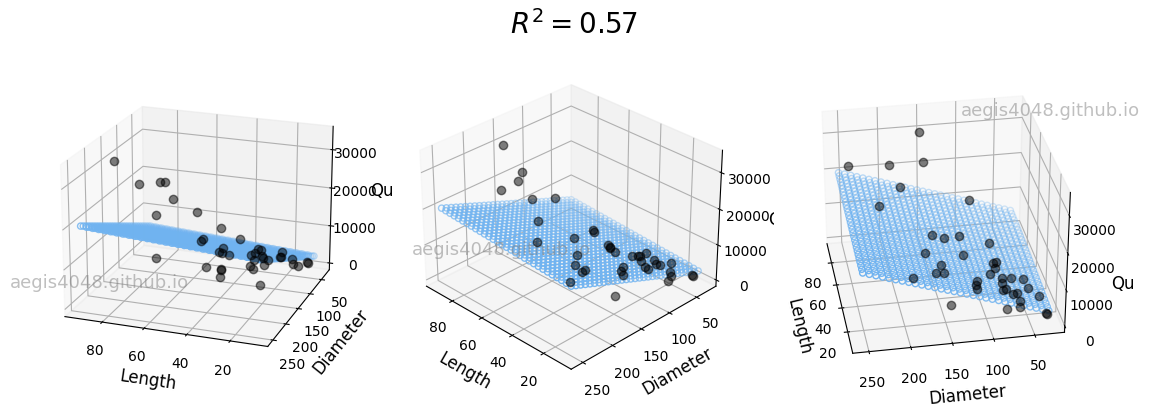

In [95]:
x0 = X_train[:, 0] #area
x1 = X_train[:, 1] # length
z = y_train

############################################## Plot ################################################

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]
z_series = pd.Series(z.flatten())


for ax in axes:
    ax.plot(x0, x1, z_series, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx0_pred.flatten(), xx1_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Diameter', fontsize=12)
    ax.set_zlabel('Qu', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=20, azim=110)
ax2.view_init(elev=30, azim=135)
ax3.view_init(elev=30, azim=170)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

#### Another plot

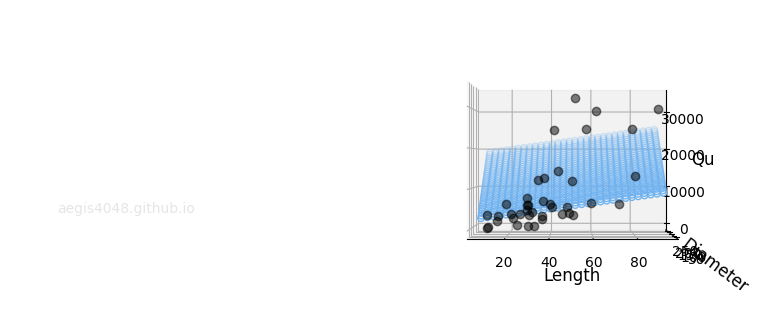

In [96]:
predicted2 = svm_reg1.predict(model_viz)

############################################## Plot ################################################

fig = plt.figure(figsize=(12, 4))
ax = fig.gca(projection='3d')

ax.plot(x0, x1, z_series, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)

#ax.scatter(xx0_pred.flatten(), xx1_pred.flatten(), predicted, facecolor='red', s=20, edgecolor='red')
ax.scatter(xx0_pred.flatten(), xx1_pred.flatten(), predicted2, facecolor=(0,0,0,0),   edgecolor='#70b3f0')


ax.set_xlabel('Length', fontsize=12)
ax.set_ylabel('Diameter', fontsize=12)
ax.set_zlabel('Qu', fontsize=12)
#ax.locator_params(nbins=4, axis='x')
#ax.locator_params(nbins=5, axis='x')
ax.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=10, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.2)
ax.view_init(elev=0, azim=270)

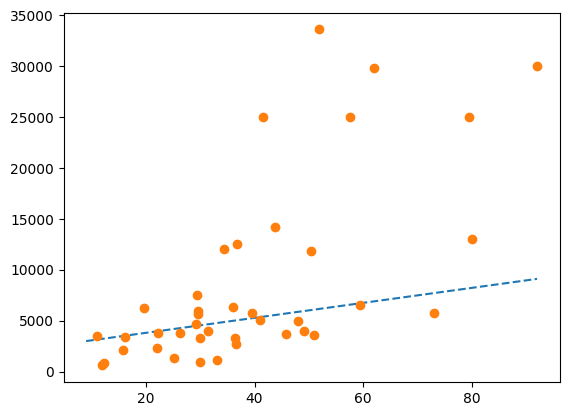

In [97]:
fig = plt.figure()
ax = fig.gca()

ax.plot(xx0_pred[0,:],predicted2[:30], '--')
ax.plot(x0, z, 'o')

In [98]:
#te=xx0_pred.flatten()
predicted2[:30]

array([2997.034, 3207.77 , 3418.507, 3629.243, 3839.979, 4050.715,
       4261.451, 4472.187, 4682.923, 4893.659, 5104.396, 5315.132,
       5525.868, 5736.604, 5947.34 , 6158.076, 6368.812, 6579.548,
       6790.285, 7001.021, 7211.757, 7422.493, 7633.229, 7843.965,
       8054.701, 8265.437, 8476.174, 8686.91 , 8897.646, 9108.382])

Saving figure svm_regression_plot


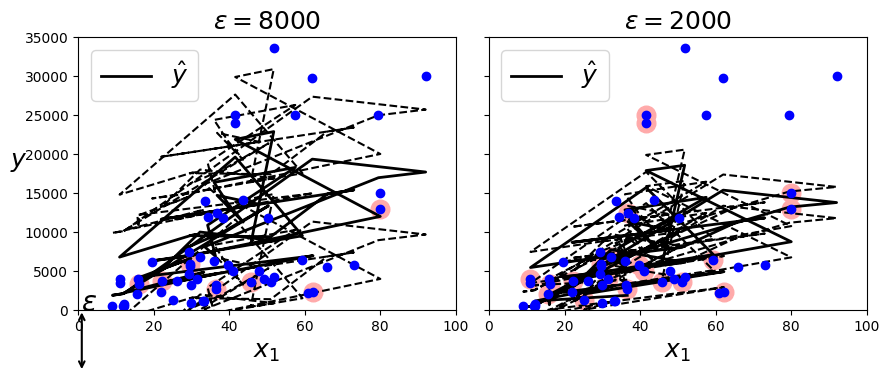

In [99]:
def plot_svm_regression_2(svm_reg, X, y, axes): # for multi-variables
#    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
#    y_pred = svm_reg.predict(x1s)
    y_pred = svm_reg.predict(X)
    x1s = X[:,0].T
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_,0], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X[:,0], y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)
#def plot_svm_regression(svm_reg, X, y, axes):
# for Len only
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression_2(svm_reg1, X, y, [0, 100, 0, 35000])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression_2(svm_reg2, X, y, [0, 100, 0, 35000])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()


fig.tight_layout()



------------------------------------------
#### Decision Tree
    "Hands on .. " Chap 6.
#### Regression

In [100]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [101]:
tree_reg.fit(X_train,y_train)
r1 = tree_reg.score(X_train, y_train)
r2 = tree_reg.score(X_test, y_test)
print ("train set R^2: {:.2f}".format(r1))
print ("test set R^2: {:.2f}".format(r2))
print ("{:.3f}".format(r2))

train set R^2: 0.99
test set R^2: 0.78
0.777


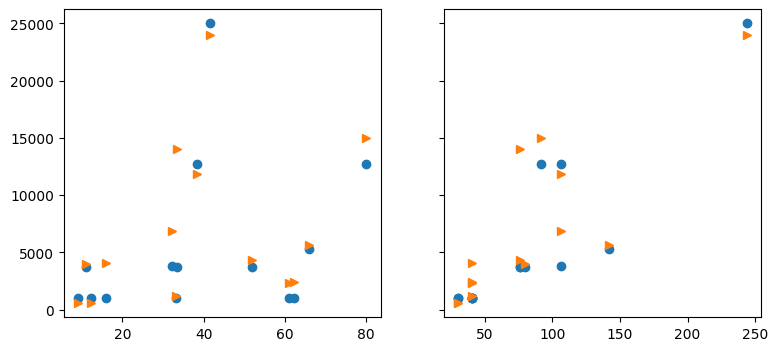

In [102]:
pred_tree = tree_reg.predict(X_test)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plt.plot(X_test[:,0], pred_tree, 'o')
plt.plot(X_test[:,0], y_test, '>')

plt.sca(axes[1])
plt.plot(X_test[:,1], pred_tree, 'o')
plt.plot(X_test[:,1], y_test, '>')

In [103]:
x0 = np.full((20,1), 30)
#x1 = np.linspace(1,100, 20)
x1 = np.linspace(1,100, 20).reshape(-1, 1)
#x01  = np.concatenate((x0, x1), axis=0)  # Equivalent to vstack
x01  = np.concatenate((x0, x1), axis=1)  # Equivalent to hstack

In [104]:
df.describe().loc[['max','min'],['Qu','Len','Dia', 'mean_N','NB']]

Qu   Len    Dia  mean_N    NB
max  33611.0  92.0  253.0    48.0  66.0
min    550.0   9.1   30.5     2.8   4.0

In [105]:
# Hands on P183

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=4,  min_samples_leaf=10)
#tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=4,  min_samples_leaf=1)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Saving figure tree_regression_plot


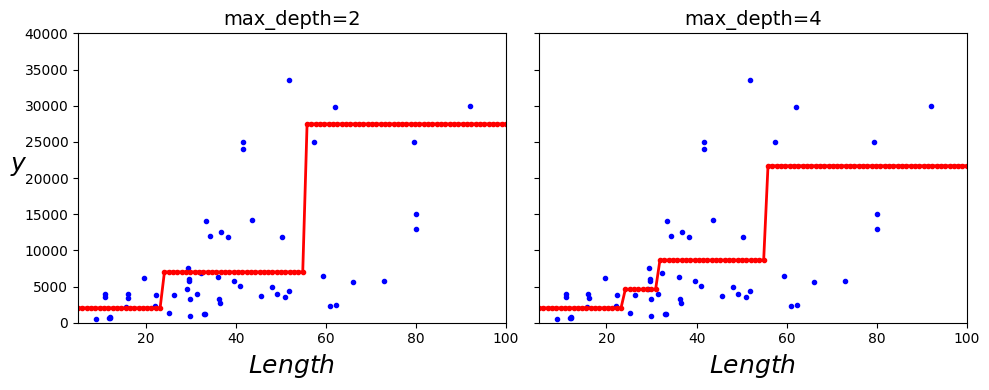

In [106]:
#def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
def plot_regression_predictions(tree_reg, X, y, axes=[5, 100, 0, 40000], ylabel="$y$"):
    x0 = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
    x1 = np.linspace(30,250, 100).reshape(-1, 1)
    x2 = np.linspace(5,50, 100).reshape(-1, 1)
    x3 = np.linspace(5,50, 100).reshape(-1, 1)

#    x1 = np.full((100,1), 100) #dia = 100
#    x2 = np.full((100,1), 30) #mean_N = 30
#    x3 = np.full((100,1), 30) #NB = 30
    xs  = np.concatenate((x0, x1, x2, x3), axis=1)  # Equivalent to hstack
    y_pred = tree_reg.predict(xs)
    plt.axis(axes)
    plt.xlabel("$Length$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X[:,0], y, "b.")
    plt.plot(x0, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
#for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
#    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
#plt.text(0.21, 0.65, "Depth=0", fontsize=15)
#plt.text(0.01, 0.2, "Depth=1", fontsize=13)
#plt.text(0.65, 0.8, "Depth=1", fontsize=13)
#plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
#for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
#    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
#for split in (0.0458, 0.1298, 0.2873, 0.9040):
#    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
#plt.text(20, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=4", fontsize=14)

save_fig("tree_regression_plot")

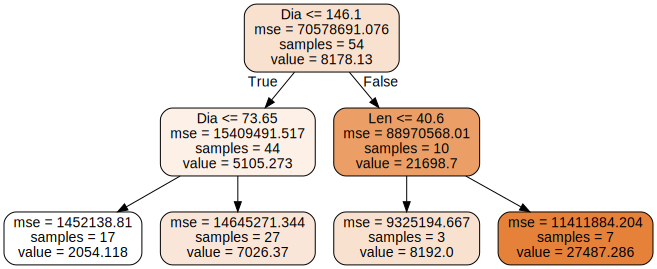

In [107]:
import graphviz
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg1,
#        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        out_file="regression_tree.dot",
        feature_names=["Len", 'Dia', 'mean_N', "NB"],
        rounded=True,
        filled=True)

with open("regression_tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

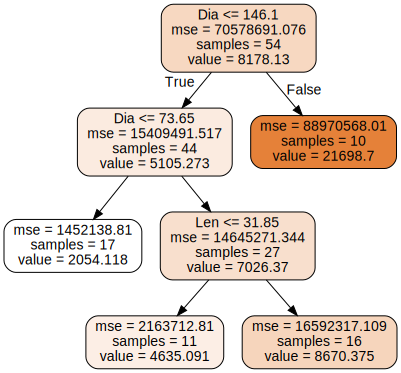

In [108]:
export_graphviz(
        tree_reg2,
        out_file=os.path.join(IMAGES_PATH, "regression_tree2.dot"),
#        out_file="regression_tree.dot",
        feature_names=["Len", 'Dia', 'mean_N', "NB"],
        rounded=True,
        filled=True)
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree2.dot"))


In [109]:
# for length only, one feature
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=4,  min_samples_leaf=10)
#tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=4,  min_samples_leaf=1)
tree_reg1.fit(X[:,0].reshape(-1, 1), y)
tree_reg2.fit(X[:,0].reshape(-1, 1), y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Saving figure tree_regression_plot


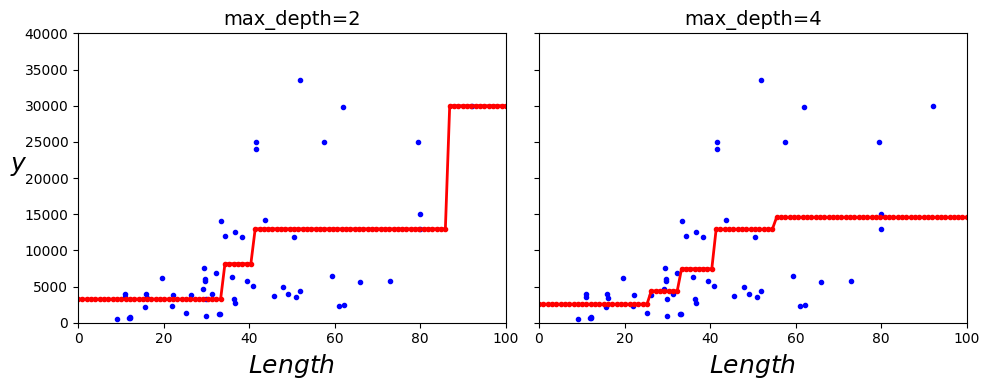

In [110]:
#def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
def plot_regression_predictions(tree_reg, X, y, axes=[0, 100, 0, 40000], ylabel="$y$"):
    xs = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
#    x1 = np.full((100,1), 100) #dia = 100
#    x2 = np.full((100,1), 30) #mean_N = 30
#    x3 = np.full((100,1), 30) #NB = 30
    y_pred = tree_reg.predict(xs)
    plt.axis(axes)
    plt.xlabel("$Length$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(xs, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X[:,0].reshape(-1, 1), y)
#for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
#    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
#plt.text(0.21, 0.65, "Depth=0", fontsize=15)
#plt.text(0.01, 0.2, "Depth=1", fontsize=13)
#plt.text(0.65, 0.8, "Depth=1", fontsize=13)
#plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X[:,0].reshape(-1, 1), y, ylabel=None)
#for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
#    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
#for split in (0.0458, 0.1298, 0.2873, 0.9040):
#    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
#plt.text(20, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=4", fontsize=14)

save_fig("tree_regression_plot")



In [111]:
#import mglearn
#tree = mglearn.plots.plot_tree_not_monotone()
#display(tree)

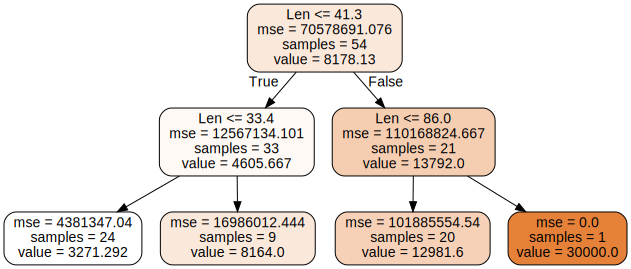

In [112]:
import graphviz
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg1,
#        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        out_file="regression_tree3.dot",
        feature_names=["Len" ],
        rounded=True,
        filled=True)

with open("regression_tree3.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

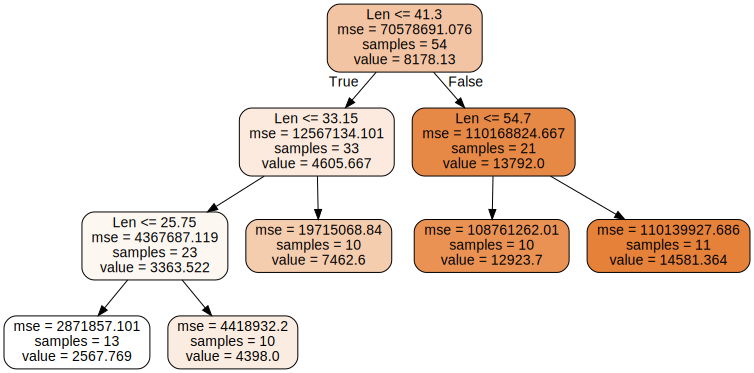

In [113]:
export_graphviz(
        tree_reg2,
        out_file=os.path.join(IMAGES_PATH, "regression_tree4.dot"),
#        out_file="regression_tree.dot",
        feature_names=["Len" ],
        rounded=True,
        filled=True)
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree4.dot"))


---
### Ensemble Learning and Random Forests
**"Hands on ..." chp 7** - ***an ensemble of Decision Trees*** is called ***a Random Forest***, and despite its simplicity,
this is one of the most powerful Machine Learning algorithms available today.

The most popular **Ensemble methods**, including ***bagging, boosting, and stacking***.
- Voting Classifiers : hard voting, soft voting
- Bagging and pasting : to use the same training algorithm for every predictor and train them on different random subsets of the training set
    - bdgging : sampling with replacement, bootstrap aggregating
    - pasting : sampling without replacement
- Out-of-Bag Evaluation
- Random Patches and Random Subspaces
- Random Forests : Extra-Trees(Extremely Randomized Trees ensemble), Feature Importance
- Boosting : AdaBoost(Adaptive Boosting), Gradient Boosting(Gradient Boosted Regression Trees (GBRT))
          XGBoost(Extreme Gradient Boosting)
- Stacking : stacked generalization

### Random Forests
Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead
use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees (similarly, there is
a RandomForestRegressor class for regression tasks).



# Move to the other file !!!
### 03 Ensemble Learning

---






#### Fine-tune the model
* *grid search* - for hyperparameters
* *randomized search* - for hyperparameters

* *ensemble methods* - RandomForest, bagging, stacking etc.

* *analyze the best models and their errors*
* *evaluate the system on the test set*

---

#### Lanunch, monitor, and maintain the system